In [1]:
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
import numpy as np

with open("Number_21.txt") as data:
    sample = data.read().split()
    for i in range(len(sample)):
        num = sample[i].split('e')
        sample[i] = float(num[0])*10**int(num[1])

sample = np.array(sample)
sample.sort()
print(sample)

[ 0.02739073  0.04156933  0.07580032  0.09833244  0.12781014  0.12854903
  0.16553469  0.17607677  0.24021695  0.28593196  0.36252538  0.51731893
  0.59144665  0.59823441  0.78882901  0.80135923  0.93752611  1.0422571
  1.1161189   1.1914555   1.1991132   1.2585241   1.2973633   1.3529027
  1.4998562   1.5438917   1.7565771   1.7992207   1.8227638   1.8930499
  2.0037269   2.2975056   2.3054541   2.3252985   2.3302459   2.3936683
  2.5235126   2.5926412   2.7119592   2.7786307   2.8462158   2.9756349
  2.9982935   3.0029919   3.3465248   3.4053321   3.8658725   3.9654398
  4.0703138   4.0737528   4.7901029   4.9327902   5.0964539   5.3989662
  5.4766391   5.7457303   8.7375778   8.7401449  10.904853   13.049437  ]


In [ ]:
print(f"Среднее: {round(np.mean(sample), 4)}")
print(f"Дисперсия: {round(np.var(sample, ddof=1), 4)}")
print(f"Кф Асимметрии: {round(skew(sample, bias=False), 4)}")
print(f"Эксцесс: {round(kurtosis(sample, bias=False),4)}")

In [ ]:
n = len(sample)
mean = round(np.mean(sample), 4)
res = 0
for elem in sample:
    res+=(elem - mean)**2
res/=(n-1)
asimm = 0
exc = 0
check = 0
mu = 0
for elem in sample:
    asimm+=((elem-mean)/np.sqrt(res))**3
    exc+=((elem-mean)/np.sqrt(res))**4
    check+=(elem-mean)**2
    mu+=(elem-mean)**4
asimm = asimm * n/(n-1)/(n-2)
exc = exc*n*(n+1)/(n-1)/(n-2)/(n-3) - 3*((n-1)**2)/(n-2)/(n-3)
check = (n*(n**2-2*n+3)*mu/n - 3*n*(2*n-3)*(check**2)/n**2)/(n-1)/(n-2)/(n-3)/res**2 - 3

print(mean, round(res,4), round(asimm,4), round(exc,4))
print(check)

Кф асимметрии: больше веса в левом хвосте распределения
Кф эксцесса: Островершинное распределение

In [ ]:
import statsmodels.api as sm

x = np.linspace(min(sample), max(sample), 1000)
b = [0, 1.5]
b_dop = list(np.linspace(2.85, max(sample),6))
b+=b_dop
ecdf = sm.distributions.ECDF(sample)
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(sample, density=True, bins=b, edgecolor='white')
ax[0].grid()
ax[0].set_title('Гистограмма')

ax[1].step(x, ecdf(x))
ax[1].grid()
ax[1].set_title('Эмпирическая функция распределения')

f.tight_layout()

Доверительные полосы:

In [ ]:
n = len(sample)
lower_bound_1 = np.array([max(Fn - 1.36/np.sqrt(n), 0) for Fn in ecdf(x)])
upper_bound_1 = np.array([min(Fn + 1.36/np.sqrt(n), 1) for Fn in ecdf(x)])
lower_bound_2 = np.array([max(Fn - 1.22/np.sqrt(n), 0) for Fn in ecdf(x)])
upper_bound_2 = np.array([min(Fn + 1.22/np.sqrt(n), 1) for Fn in ecdf(x)])
f, ax = plt.subplots(1, 1, figsize=(19, 12))

ax.plot(x, ecdf(x), color='c', label='Эмпирическая функция распределения')
ax.plot(x, lower_bound_1, color='r', label=r"$\gamma$" + f" = {0.95}")
ax.plot(x, upper_bound_1, color='r')
ax.plot(x, lower_bound_2, color='y', label=r"$\gamma$" + f" = {0.90}")
ax.plot(x, upper_bound_2, color='y')
ax.grid()
ax.legend()

кф асимметрии != 0 => не нормальное распределение
кф асимметрии > 0 => правый хвост длинее левого

эксцесс: > 0 => высоковершинное распределение

По гистограмме и вышеприведенным рассуждениям распределение может быть:
 - Экспоненциальное
 - Хи-квадрат

Проверка гипотезы на основе хи-квадрат Фишера:

In [ ]:
from scipy.stats import expon, chi2

def chi2_check(func, div_part, lamda, beta, sample):
    borders = np.linspace(min(sample), max(sample), div_part + 1)
    if len([number for number in sample if borders[-2] < number < borders[-1]]) < 5:
        border = [borders[-2], borders[-1]]
        while len([number for number in sample if border[0] < number < border[1]]) < 5:
            border[0]-=1
    borders = np.linspace(sample[0], border[0], div_part).tolist()
    borders.append(border[1])
    n = len(sample)
    res = 0
    for i in range(div_part):
        if beta is None:
            p = func(borders[i+1], lamda) - func(borders[i], lamda)
        else:
            p = func(borders[i+1], lamda, beta) - func(borders[i], lamda, beta)
        v = len([number for number in sample if borders[i] < number < borders[i + 1]])
        res += (v - n*p)**2 / (n*p)
    return res
    

In [ ]:
from scipy.optimize import minimize

def th_df_expon(x, lamda):
    return expon.cdf(x, scale=lamda)
def th_df_chi2(x, df=n):
    return chi2.cdf(x,n)

split = [4, 6, 9]
quant_hi = [5.991, 9.488, 14.067]

theta_exp = []
theta_chi2 = []

print("Экспоненциальное распределение")
for chi in quant_hi:
    print(f"Расчет для степени свободы = {split[quant_hi.index(chi)]-2}")
    for part in split:
        chi_2 = lambda arg: chi2_check(th_df_expon, part, arg, None, sample)
        result = minimize(chi_2, 1, method='TNC', tol=1e-15)
        print(f"Значение при числе разбиения = {part}: {result['fun']}, параметр: {result['x']}")
        theta_exp.append(result['x'])
        print(result['fun'] < chi)
    print()

print()
print("Распределение Хи-квадрат")
for chi in quant_hi:
    print(f"Расчет для степени свободы = {split[quant_hi.index(chi)]-2}")
    for part in split:
        chi_2 = lambda arg: chi2_check(th_df_chi2, part, arg, None, sample)
        result = minimize(chi_2, 1, method='TNC', tol=1e-15)
        print(f"Значение при числе разбиения = {part}: {result['fun']}, параметр: {result['x']}")
        theta_chi2.append(result['x'])
        print(result['fun'] < chi)
    print()

МП - оценка экспоненциального распределения

In [ ]:
# from math import exp, log
# from scipy.special import gamma
# def func_exp(param):
#     res = 0
#     for elem in sample:
n_chi2 = chi2.fit(sample, floc=0, fscale=1)
#         a = 1./param*exp(-elem/param)
#         res+=log(1./param*exp(-elem/param))
#     return res
# result = minimize(func_exp, 2, method='TNC', tol=1e-6)
# print(result['x'])
_, scale_exp = expon.fit(sample, floc=0)
print(f"Параметр равен {round(scale_exp, 4)}")

In [ ]:
n_chi2 = chi2.fit(sample, floc=0, fscale=1)
print(f"Параметр равен {round(n_chi2[0], 4)}")

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 8))
x = np.linspace(0, max(sample), 1000)
ax[0].hist(sample, density=True, label='Гистограмма', bins=b)
ax[0].plot(x, expon.pdf(x, scale=scale_exp), label="Expon pdf")
ax[0].plot(x, chi2.pdf(x, df=n_chi2[0]), label="Chi2 pdf")
# ax[0].plot(x, gamma.pdf(x, mean_gamma[0],1/mean_gamma[1]), label="Gamma pdf")
ax[0].grid()
ax[0].legend()
ax[0].set_title("Гистограмма с плотностями вероятности")

ax[1].plot(x, ecdf(x), label='Эмпирическая функция распределения')
ax[1].plot(x, expon.cdf(x, scale=scale_exp), label="Expon cdf")
ax[1].plot(x, chi2.cdf(x, df=n_chi2[0]), label="Chi2 cdf")
# ax[1].plot(x, chi2.cdf(x, mean_gamma[0],1/mean_gamma[1]), label="Gamma cdf")
ax[1].grid()
ax[1].legend()
ax[1].set_title('Э.ф.р. и функции распределения')

In [ ]:
print("Экспоненциальное распределение:")
mean, var, skew, kurt = expon.stats(mean_exponlamda, moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

In [ ]:
print("Распределение хи-квадрат:")
mean, var, skew, kurt = chi2.stats(mean_chi2n, moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

In [ ]:
print("Гамма распределение:")
mean, var, skew, kurt = gamma.stats(mean_gamma[0],1/mean_gamma[1], moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

Text(0.5, 1.0, 'Э.ф.р. и функции распределения')

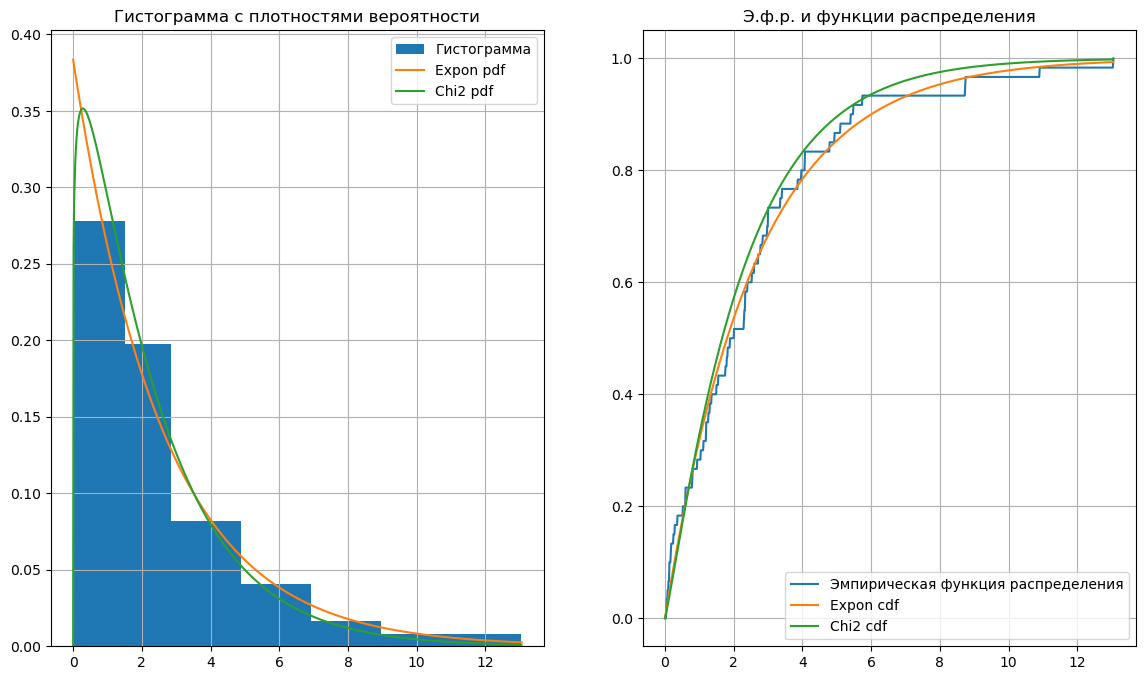

In [94]:
f, ax = plt.subplots(1, 2, figsize=(14, 8))
x = np.linspace(0, max(sample), 1000)
ax[0].hist(sample, density=True, label='Гистограмма', bins=b)
ax[0].plot(x, expon.pdf(x, scale=scale_exp), label="Expon pdf")
ax[0].plot(x, chi2.pdf(x, df=n_chi2[0]), label="Chi2 pdf")
# ax[0].plot(x, gamma.pdf(x, mean_gamma[0],1/mean_gamma[1]), label="Gamma pdf")
ax[0].grid()
ax[0].legend()
ax[0].set_title("Гистограмма с плотностями вероятности")

ax[1].plot(x, ecdf(x), label='Эмпирическая функция распределения')
ax[1].plot(x, expon.cdf(x, scale=scale_exp), label="Expon cdf")
ax[1].plot(x, chi2.cdf(x, df=n_chi2[0]), label="Chi2 cdf")
# ax[1].plot(x, chi2.cdf(x, mean_gamma[0],1/mean_gamma[1]), label="Gamma cdf")
ax[1].grid()
ax[1].legend()
ax[1].set_title('Э.ф.р. и функции распределения')

In [108]:
print("Экспоненциальное распределение:")
mean, var, skew, kurt = expon.stats(mean_exponlamda, moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

Экспоненциальное распределение:
    Среднее = 3.529964388310313
    Дисперсия = 1.0
    Кф асимметрии = 2.0
    Эксцесс = 6.0


In [109]:
print("Распределение хи-квадрат:")
mean, var, skew, kurt = chi2.stats(mean_chi2n, moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

Распределение хи-квадрат:
    Среднее = 2.4749638386088564
    Дисперсия = 4.949927677217713
    Кф асимметрии = 1.797879434055296
    Эксцесс = 4.848555689098487


In [113]:
print("Гамма распределение:")
mean, var, skew, kurt = gamma.stats(mean_gamma[0],1/mean_gamma[1], moments='mvsk')
print(f"    Среднее = {mean}\n    Дисперсия = {var}\n    Кф асимметрии = {skew}\n    Эксцесс = {kurt}")

Гамма распределение:
    Среднее = 2.0805503902220526
    Дисперсия = 2.0542768964280698
    Кф асимметрии = 1.395405738779742
    Эксцесс = 2.9207357637291564
